# Bank Marketing Campaign Analysis

### 1. Import Libraries

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

### 2. Load Data

In [ ]:
# Define file paths
zip_file_path = 'Bank Marketing Dataset.zip'  
extracted_folder = 'Bank_Marketing_Data' 

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Load the dataset
csv_file_name = os.path.join(extracted_folder, 'bank-full.csv')
df = pd.read_csv(csv_file_name)

### 3. Clean Data

In [3]:
# Convert target variable to binary format
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Drop 'duration' as it is not a practical predictive feature
df = df.drop(columns=['duration'])

# Handle categorical variables
X = pd.get_dummies(df.drop(columns=['y']), drop_first=True)
y = df['y']

### 4. Split Data and Standardize Features

In [5]:
# Split dataset before SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

### 5. Train Model

In [6]:
# Hyperparameter tuning for Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)
best_rf = grid_search.best_estimator_

# Train an XGBoost model
xgb = XGBClassifier(scale_pos_weight=sum(y_train_smote == 0) / sum(y_train_smote == 1), random_state=42)
xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### 6. Evaluate Models

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     11977
           1       0.49      0.32      0.39      1587

    accuracy                           0.88     13564
   macro avg       0.70      0.64      0.66     13564
weighted avg       0.86      0.88      0.87     13564

ROC-AUC Score: 0.6386


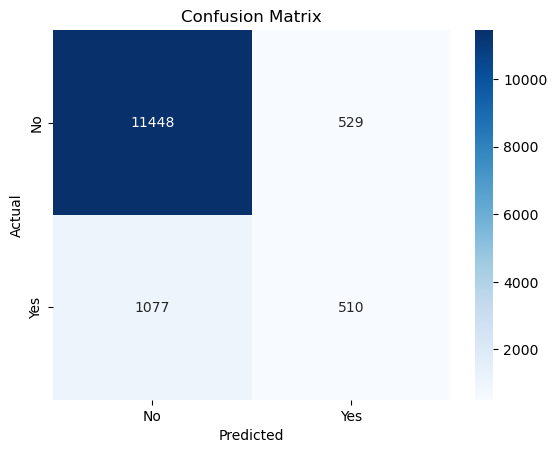

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     11977
           1       0.46      0.35      0.40      1587

    accuracy                           0.88     13564
   macro avg       0.69      0.65      0.67     13564
weighted avg       0.86      0.88      0.87     13564

ROC-AUC Score: 0.6500


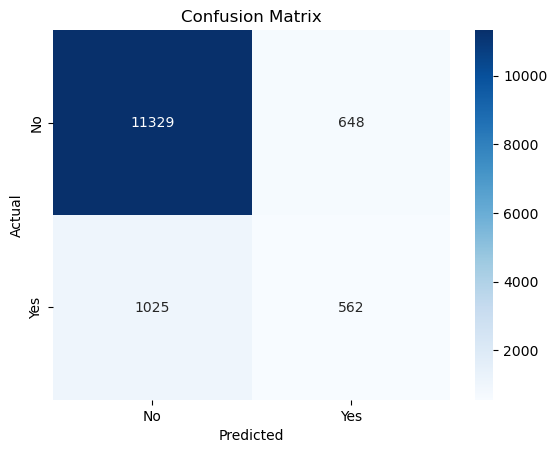

In [7]:
# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

print("Random Forest Model Performance:")
evaluate_model(best_rf, X_test, y_test)

print("XGBoost Model Performance:")
evaluate_model(xgb, X_test, y_test)